In [1]:
%matplotlib inline

In [2]:
import zipfile
with zipfile.ZipFile("../data/models/unet-ssim-loss.zip", 'r') as zip_ref:
   zip_ref.extractall("../data/models")

In [3]:
from monai.transforms import (
    NormalizeIntensity,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    SpatialCropd,
    MapTransform,
    SignalFillEmptyd,
    RandSpatialCropd,
    ScaleIntensityd,
    ScaleIntensityRanged, MaskIntensity
)

from src.ptp.patch_the_planet_utilities import *


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

DATA_DIR = Path('../data')
TARGET_DATA_DIR = DATA_DIR / 'generated_part1_nii_gz'
MODELS_DIR = DATA_DIR / 'models'
TRAINING_DIR = DATA_DIR / 'training'
os.makedirs(TRAINING_DIR, exist_ok=True)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
os.listdir(TARGET_DATA_DIR)

['seismicCubes_RFC_fullstack_2023.76346555.nii',
 'seismicCubes_RFC_fullstack_2023.76346557.nii']

In [5]:
corrupted_tf = CorruptedTransform(10, keys=['target'])

target_file = os.listdir(TARGET_DATA_DIR)[0]
target = nib.load(TARGET_DATA_DIR / target_file).get_fdata()

target = MetaTensor(torch.unsqueeze(torch.Tensor(target), 0))
print(target.shape)

data = corrupted_tf({'target': target})

torch.Size([1, 300, 300, 1259])


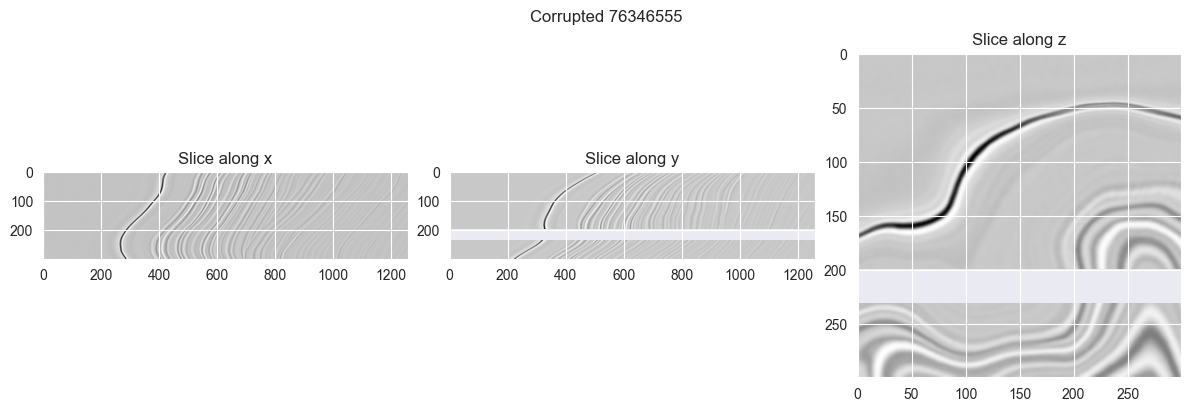

In [6]:
visualize_slices(nib.Nifti1Image(data['image'].as_tensor().numpy()[0], np.eye(4)), 150, 150, 400, f'Corrupted {target_file.split(".")[-2]}')

#### How original and training images differ

Original and corrupted images have different intensities because the later is scaled to some range - thus the same scaling will be applied to the original image

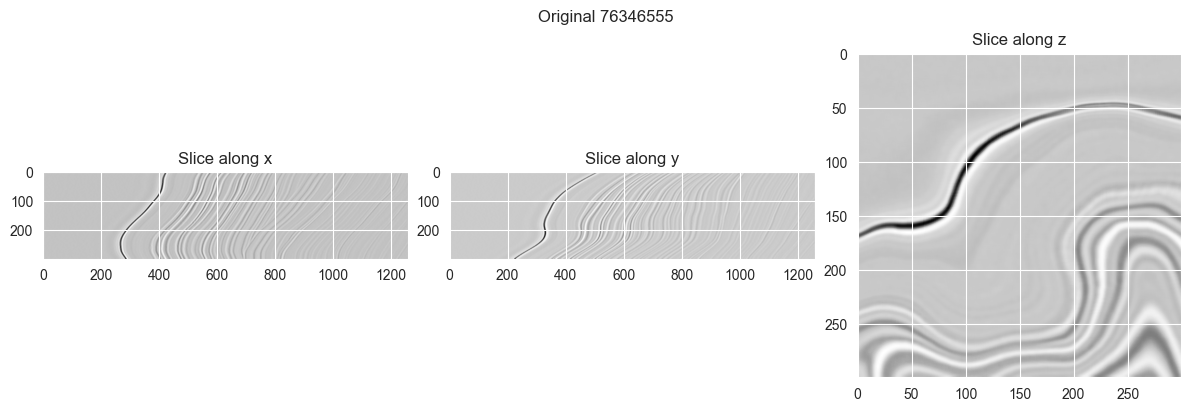

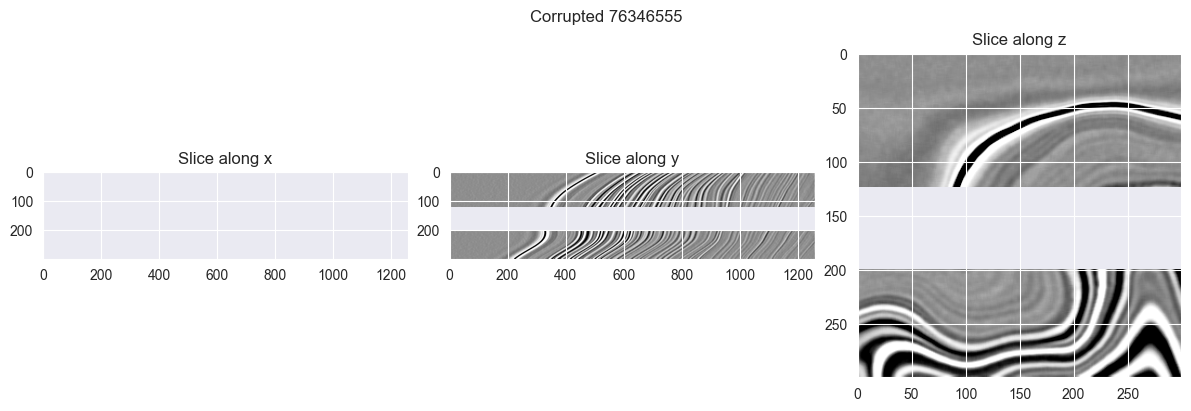

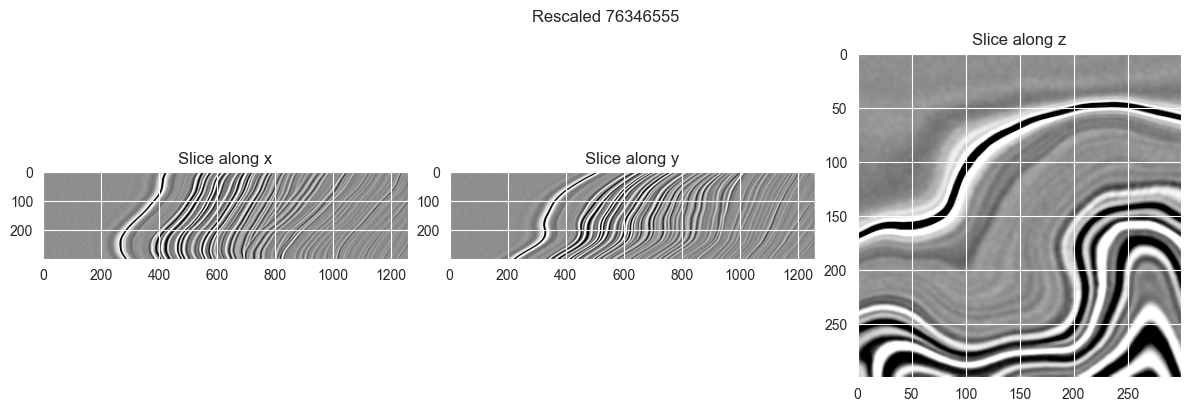

In [7]:
target_file = os.listdir(TARGET_DATA_DIR)[0]
target = nib.load(TARGET_DATA_DIR / target_file)
visualize_slices(target, 150, 150, 400, f'Original {target_file.split(".")[-2]}')
img, _, _ = training_data_generator(target.get_fdata())
target = rescale_volume(target.get_fdata())
visualize_slices(nib.Nifti1Image(img, np.eye(4)), 150, 150, 400, f'Corrupted {target_file.split(".")[-2]}')
visualize_slices(nib.Nifti1Image(target, np.eye(4)), 150, 150, 400, f'Rescaled {target_file.split(".")[-2]}')

In [8]:
class Net(pl.LightningModule):
    
    def __init__(self, percentile=25, loss_func=nn.MSELoss()):
        super().__init__()
        
        # How these shapes form?; try with different input sizes
        self._model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH
        )
        
        self.loss_function = loss_func
        self.percentile = percentile
    
    def forward(self, x):
        return self._model(x)
    
    def prepare_data(self):
        targets = sorted(os.listdir(TARGET_DATA_DIR))
        train_dict = [
            {'target': TARGET_DATA_DIR / target_name} for target_name in targets[:1]
        ]
        
        val_dict = [
            {'target': TARGET_DATA_DIR / target_name} for target_name in targets[:1]
        ]
        
        # TODO: Examine what these transformations do and whether some other transformations can be applied
        train_transforms = Compose(
            # for now each image would be normalized based on its own mean and std
            [LoadImaged(keys=['target']),
             RescaleTransform(keys=['target']),
             EnsureChannelFirstd(keys=['target']), 
             Orientationd(keys=["target"], axcodes="RAS"),
             RandSpatialCropd(keys=['target'], 
                         roi_size=(256, 256, 256), random_size=False),
             CorruptedTransform(percentile=self.percentile, keys=['target']),
             # Problem: missing areas are nans, which causes everything else to be nan
             SignalFillEmptyd(keys=['image'], replacement=256),
             ScaleIntensityd(keys=["image", "target"]),
            ]
        )
        
        val_transforms = Compose(
            # for now each image would be normalized based on its own mean and std
            [LoadImaged(keys=['target']),
             RescaleTransform(keys=['target']),
             EnsureChannelFirstd(keys=['target']), 
             Orientationd(keys=["target"], axcodes="RAS"),
             SpatialCropd(keys=['target'], roi_center=(150, 150, 750),
                         roi_size=(256, 256, 256)),
             CorruptedTransform(percentile=self.percentile, keys=['target']),
             # Problem: missing areas are nans, which causes everything else to be nan
             SignalFillEmptyd(keys=['image'], replacement=256),
             # Scale to range [0,1]
             ScaleIntensityd(keys=["image", "target"]),
            ]
        )
        
        # Cached Dataset: na RAM wrzuca; to co jest wynikiem transformow wrzuca na RAM
        # ale to wtedy nie robi tego transform 
        # Smart Cached Dataset: madre?
        self.train_data = Dataset(
            data = train_dict, 
            transform = train_transforms
        )
        
        self.val_data = Dataset(
            data = val_dict, 
            transform = val_transforms
        )
        
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_data,
            batch_size=2,
            shuffle=True,
            num_workers=2, 
            collate_fn=list_data_collate
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(self.val_data, batch_size=1, num_workers=4)
        return val_loader
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        images, targets = batch["image"], batch["target"]
        output = self.forward(images)
        loss = self.loss_function(output, targets)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {"val_loss": loss}
    
    def training_step(self, batch, batch_idx):
        images, targets, mask = batch["image"], batch["target"], batch['mask']
        output = self.forward(images)
        loss = self.loss_function(output, targets)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {"loss": loss}
        

In [9]:
net = Net()

net.prepare_data()

In [10]:
dataiter = iter(net.train_data)

In [11]:
sample = next(dataiter)

In [12]:
sample.keys()

dict_keys(['target', 'image', 'mask'])

Images are cropped because they can't fit into the memory

In [13]:
sample['image'].shape

torch.Size([1, 256, 256, 256])

In [14]:
original_pt = sample['target'].as_tensor()[0]
corrupted_pt = sample['image'].as_tensor()[0]

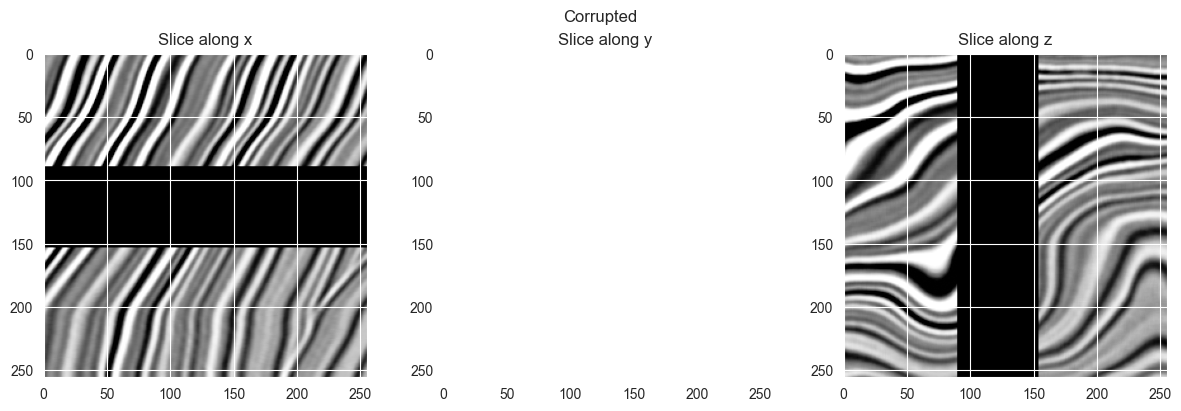

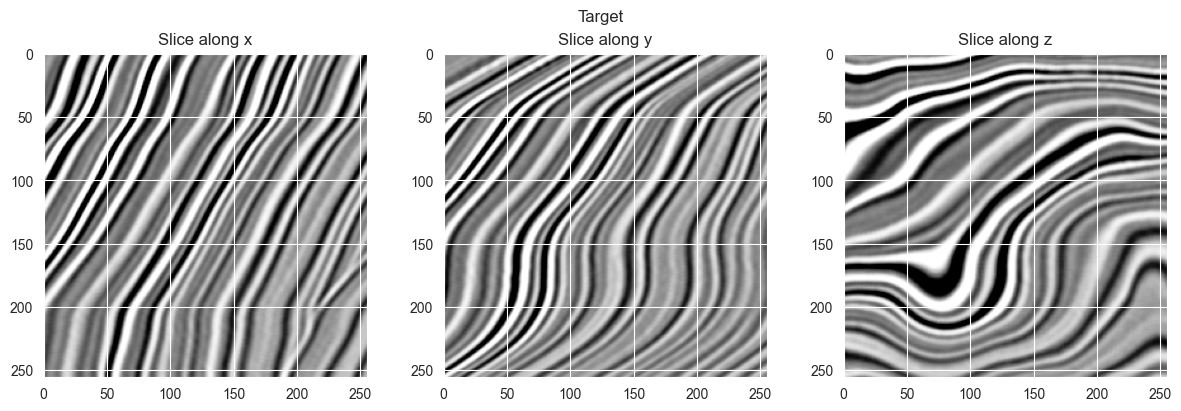

In [15]:
visualize_slices(nib.Nifti1Image(corrupted_pt.numpy(), np.eye(4)), 100, 150, 100, 'Corrupted')
visualize_slices(nib.Nifti1Image(original_pt.numpy(), np.eye(4)), 100, 150, 100, 'Target')

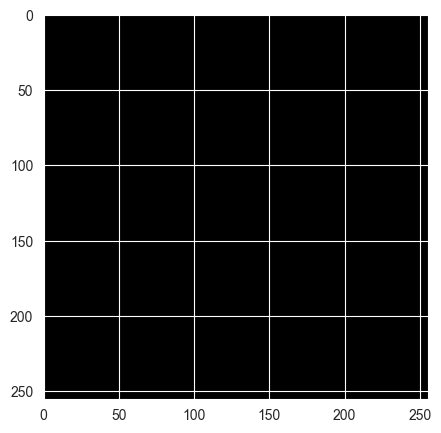

In [16]:
plt.figure(figsize=(5, 5))
plt.imshow(sample['mask'].numpy()[0, :, 100, :], cmap='gray')

In [17]:
corrupted_pt.numpy()[100, :, :]

array([[0.54956895, 0.5289601 , 0.50606143, ..., 0.85870147, 0.99609375,
        0.99609375],
       [0.55185884, 0.5266703 , 0.50148165, ..., 0.93884695, 0.99609375,
        0.99609375],
       [0.5449892 , 0.5220905 , 0.49461207, ..., 0.99609375, 0.99609375,
        0.99609375],
       ...,
       [0.76481676, 0.7144397 , 0.65261316, ..., 0.45110452, 0.4053071 ,
        0.38011855],
       [0.7716864 , 0.72130924, 0.654903  , ..., 0.4236261 , 0.38698816,
        0.36866918],
       [0.76939654, 0.7190194 , 0.654903  , ..., 0.40988687, 0.38469827,
        0.36637932]], dtype=float32)

In [18]:
original_pt.numpy()[100, :, :]

array([[0.55172414, 0.53103447, 0.508046  , ..., 0.86206895, 1.        ,
        1.        ],
       [0.55402297, 0.52873564, 0.50344825, ..., 0.9425287 , 1.        ,
        1.        ],
       [0.5471264 , 0.5241379 , 0.49655172, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.76781607, 0.7172414 , 0.6551724 , ..., 0.45287356, 0.40689656,
        0.3816092 ],
       [0.7747126 , 0.7241379 , 0.65747124, ..., 0.42528737, 0.38850576,
        0.37011495],
       [0.7724138 , 0.7218391 , 0.65747124, ..., 0.41149426, 0.3862069 ,
        0.3678161 ]], dtype=float32)

In [19]:
structural_similarity(corrupted_pt.numpy()[100, :, :], original_pt.numpy()[100, :, :], data_range=1.0)

0.7462305752117171

In [20]:
F.mse_loss(corrupted_pt[100, :, :], original_pt[100, :, :])

tensor(0.0744)

In [21]:
output = net(torch.unsqueeze(sample['image'], 0))

In [22]:
output.shape

torch.Size([1, 1, 256, 256, 256])

In [23]:
F.mse_loss(sample['target'], output)

Using a target size (torch.Size([1, 1, 256, 256, 256])) that is different to the input size (torch.Size([1, 256, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


metatensor(0.9252, grad_fn=<AliasBackward0>)

In [24]:
sample['mask'].shape

torch.Size([1, 256, 256, 256])

In [25]:
masked_target = sample['target'] * sample['mask']

In [26]:
masked_target.max()

metatensor(1.)

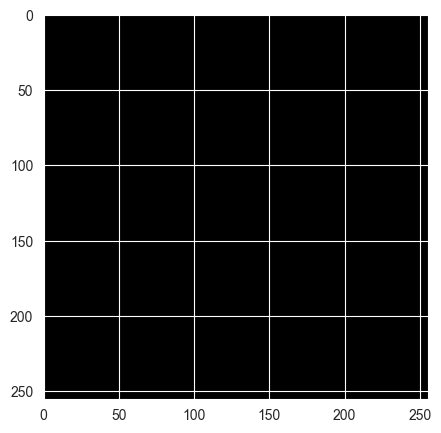

In [27]:
plt.figure(figsize=(5, 5))
plt.imshow(masked_target.numpy()[0, :, 200, :], cmap='gray')

In [28]:
sample['mask'].type(torch.bool)

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

In [29]:
nonzero_mask = torch.nonzero(masked_target).numpy()

In [30]:
nonzero_mask.shape

(3997909, 4)

In [31]:
random_slice = nonzero_mask[np.random.randint(0, nonzero_mask.shape[0])]
_, x, y, z = random_slice
print(random_slice)

[  0 207  96 134]


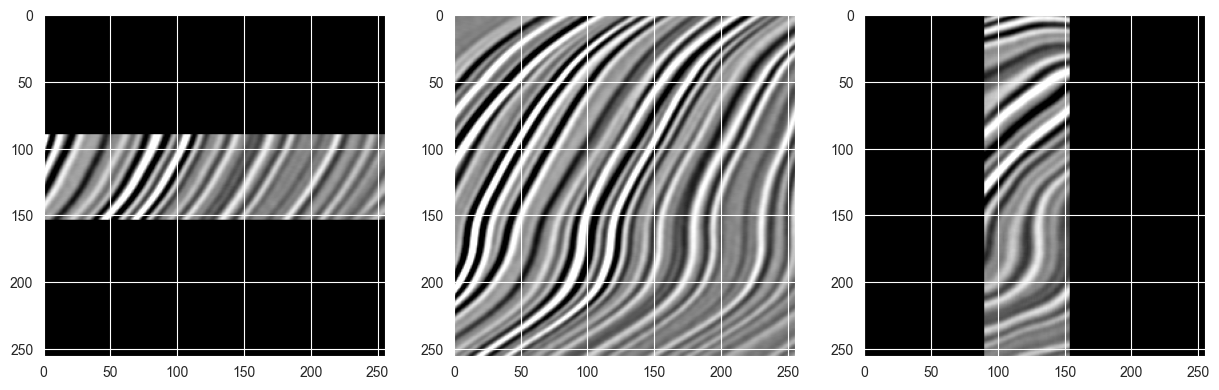

In [32]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.imshow(masked_target[0, x, :, :], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(masked_target[0, :, y, :], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(masked_target[0, :, :, z], cmap='gray')

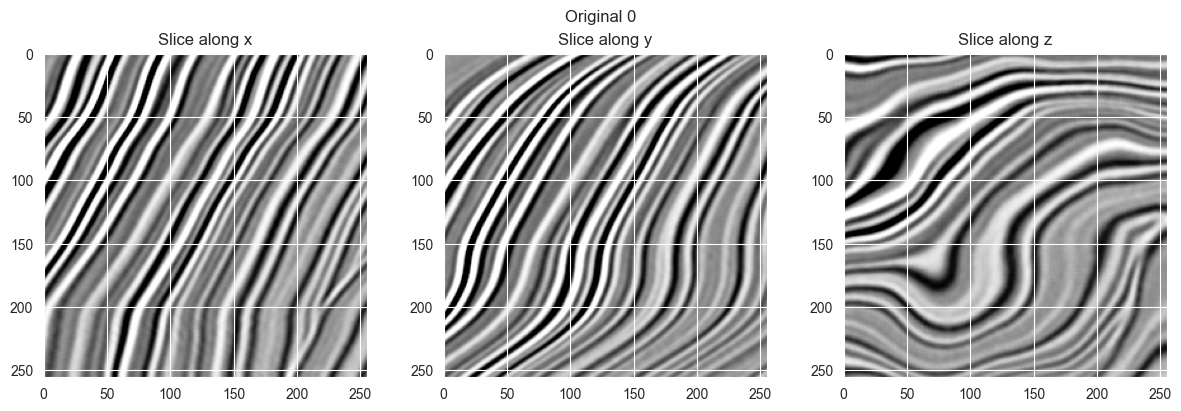

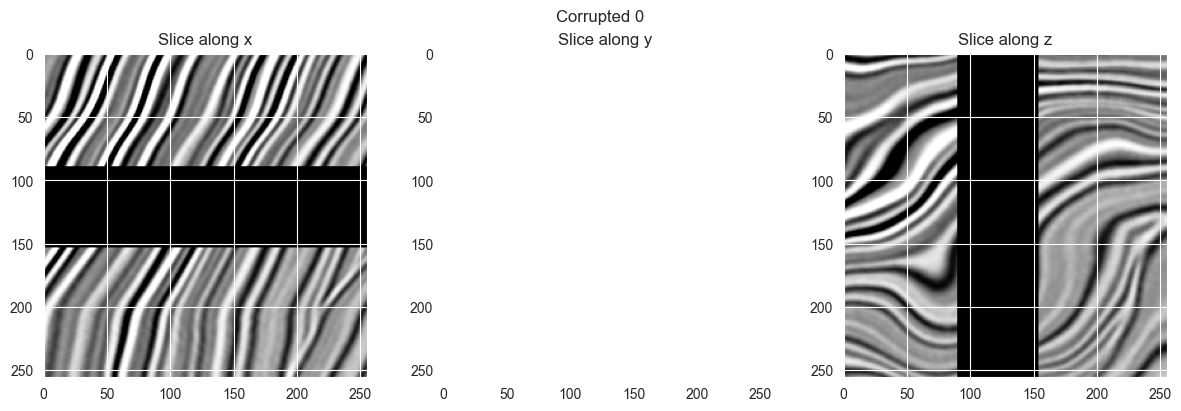

In [33]:
visualize_volumes(sample, 0, ['target', 'image'], ['Original', 'Corrupted'])

#### Problems
1. The whole volume can't fit into the memory
2. U-Net imposes constraints on the sizes of the volumes because of the down and up samplings

https://github.com/Project-MONAI/tutorials/blob/main/modules/UNet_input_size_constraints.ipynb

In [34]:
from torchmetrics.functional.image import structural_similarity_index_measure

def ssim_loss(preds, target):
    return 1 - structural_similarity_index_measure(preds, target, data_range=1.0)

In [59]:
max_epochs = 10
percentile = 5

checkpoint_dir = Path(TRAINING_DIR / 'unet-8-mse')

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)
 
net = Net(percentile=percentile, loss_func=F.mse_loss)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    default_root_dir=checkpoint_dir,
    callbacks=[checkpoint_callback],
    fast_dev_run=False, num_sanity_val_steps=0
)

trainer.fit(net)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type | Params
--------------------------------
0 | _model | UNet | 4.8 M 
--------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.232    Total estimated model params size (MB)
The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 1/1 [07:30<00:00,  0.00it/s, v_num=2, train_loss_step=0.978]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [07:32<00:00,  0.00it/s, v_num=2, train_loss_step=0.974, val_loss=0.915, train_loss_epoch=0.978]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [07:28<00:00,  0.00it/s, v_num=2, train_loss_step=0.971, val_loss=0.910, train_loss_epoch=0.974]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [07:32<00:00,  0.00it/s, v_num=2, train_loss_step=0.936, val_loss=0.912, train_loss_epoch=0.971]
Validation: |          | 0/? [00:00<?, ?it/s]

#### Predictions with MSE Loss

In [36]:
os.listdir(TRAINING_DIR / 'unet-8-mse')

['epoch=0-val_loss=0.27-train_loss=0.96.ckpt',
 'epoch=0-val_loss=0.38-train_loss=0.96.ckpt',
 'last-v1.ckpt',
 'last.ckpt',
 'lightning_logs']

In [37]:
net = Net.load_from_checkpoint(TRAINING_DIR / 'unet-8-mse/epoch=0-val_loss=0.27-train_loss=0.96.ckpt', percentile=percentile)

net.eval()
net.prepare_data()
val_loader = net.val_dataloader()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


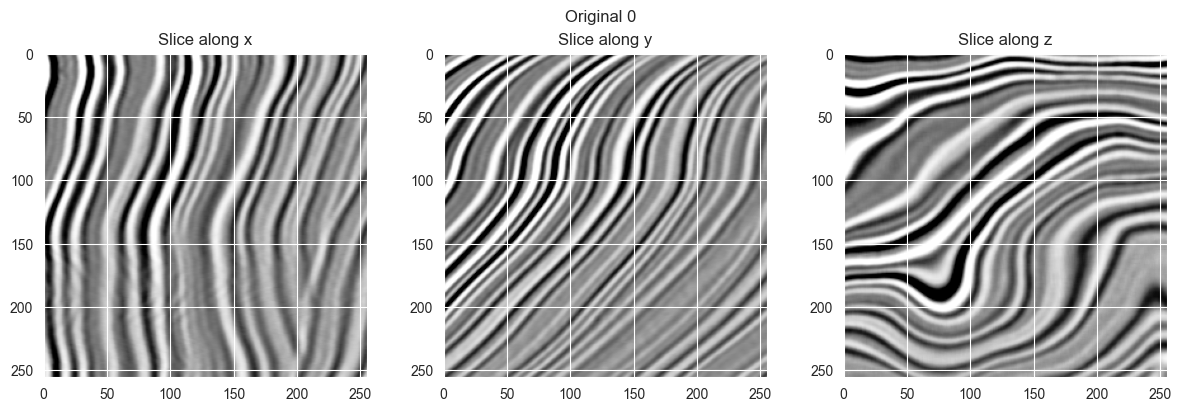

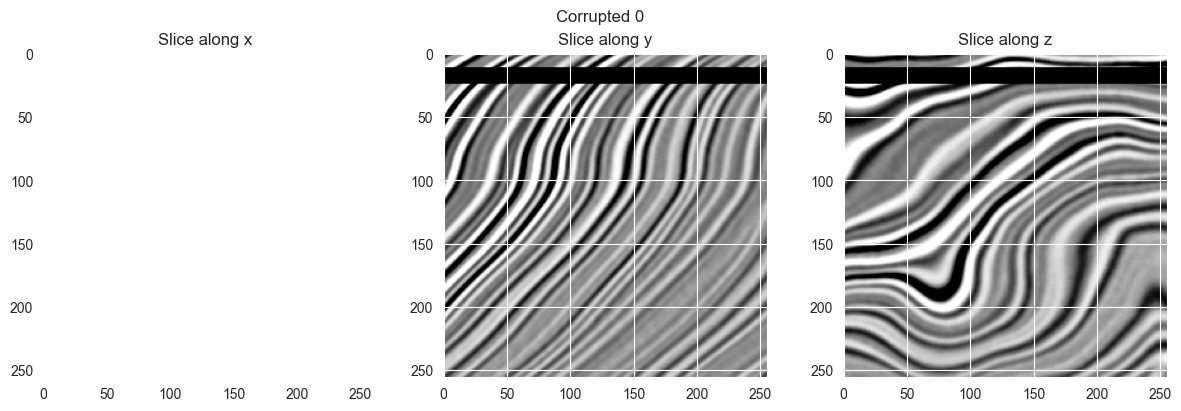

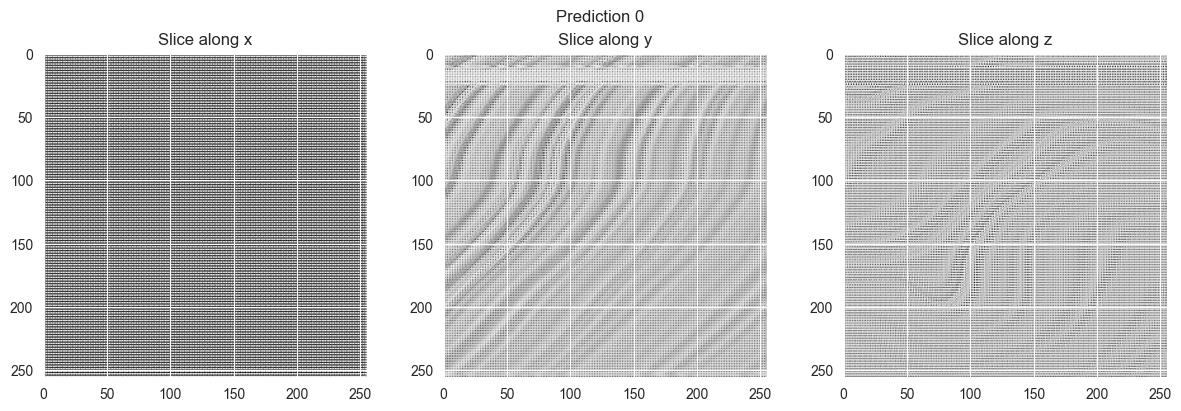

In [38]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

trainer = pl.Trainer()

for i, batch in enumerate(val_loader):
    prediction = net(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)

#### Predictions with SSIM Loss

In [48]:
os.listdir(TRAINING_DIR / 'unet-8-ssim')

['epoch=4-val_loss=0.98-train_loss=0.94.ckpt', 'last.ckpt', 'lightning_logs']

In [50]:
net = Net.load_from_checkpoint(TRAINING_DIR / 'unet-8-ssim/epoch=4-val_loss=0.98-train_loss=0.94.ckpt', percentile=percentile)

net.eval()
net.prepare_data()
val_loader = net.val_dataloader()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


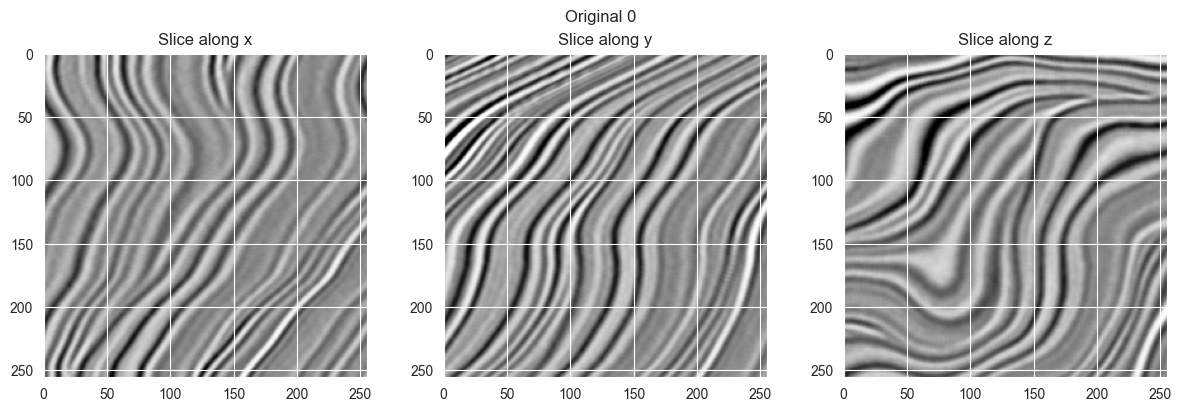

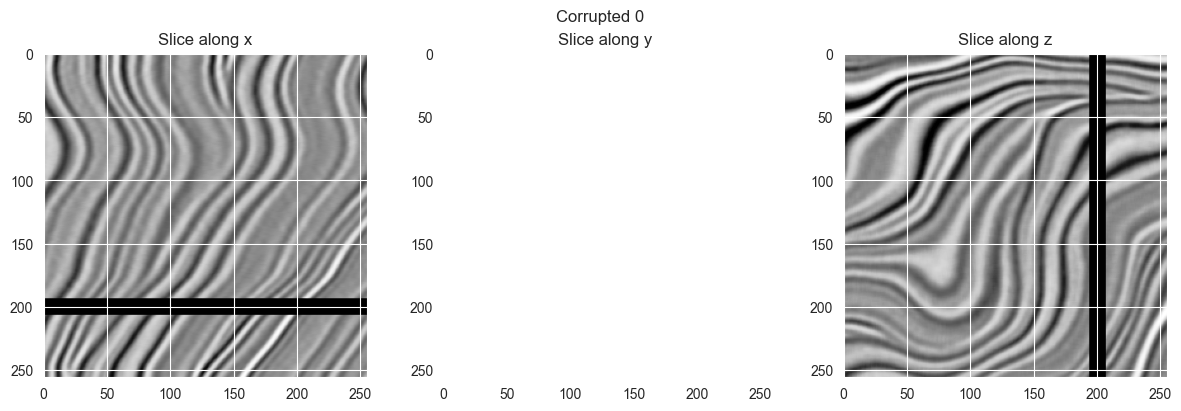

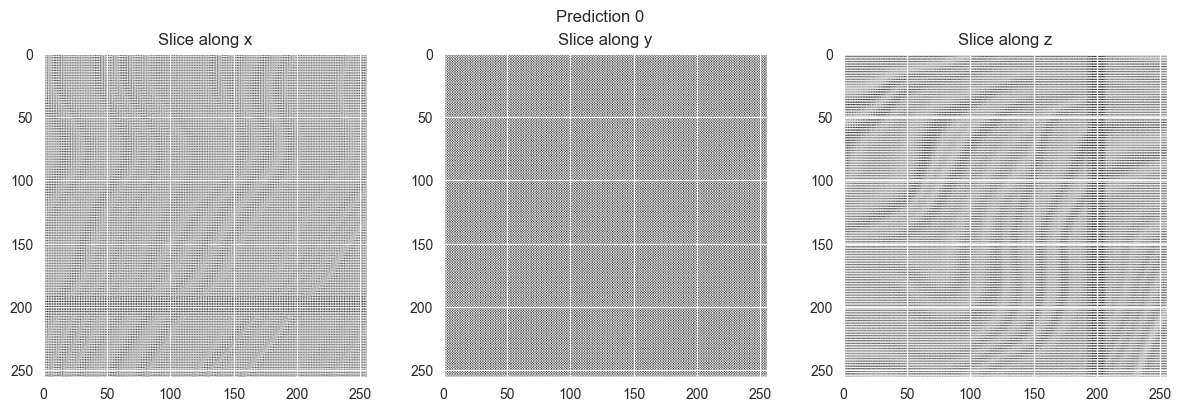

In [51]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

trainer = pl.Trainer()

for i, batch in enumerate(val_loader):
    prediction = net(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)